In [ ]:
!pip install texthero
!pip install emoji
!pip install TextBlob
!python -m textblob.download_corpora
!pip install wordcloud

import pandas as pd 
import spacy 
import seaborn as sns
import texthero as hero
import matplotlib.pyplot as plt
import re
import numpy as np

from bs4 import BeautifulSoup
from emoji import UNICODE_EMOJI
from google.colab import drive
from textblob import TextBlob
from textblob import Word
from texthero import preprocessing
from wordcloud import WordCloud
nlp = spacy.load('en_core_web_sm')

**Stage 1:** Setting up Data

In [99]:
df_pre = pd.read_csv('https://raw.githubusercontent.com/PannaD8ta/YT_Comments_Sentiment_Analysis/master/before_scandal.csv',  encoding="ISO-8859-1")
df_post = pd.read_csv('https://raw.githubusercontent.com/PannaD8ta/YT_Comments_Sentiment_Analysis/master/after_scandal.csv',  encoding="ISO-8859-1")


In [100]:
df_pre.head()


,Unnamed: 0,comment,comment_id,author_url,author_name,reply_count,like_count,date,vidid,total_reply_counts,vid_title,just_date
0,0,"Most of all, you are so handsome!!!",UgyiuJXWZDpVR8FS4dN4AaABAg,http://www.youtube.com/channel/UCfTvPOvkLYtgBP...,ì¶ë²ë ë°°,0,0,2020-12-26 23:31:43+00:00,4eIBisqx9_g,0,YOLO Object Detection (TensorFlow tutorial),2020-12-26
1,1,very nice explanation thank you,UgxLfL6YZOZErsJefMd4AaABAg,http://www.youtube.com/channel/UCR04W8e_43hIhk...,Batselem Jagvaral,0,0,2020-12-11 09:16:19+00:00,4eIBisqx9_g,0,YOLO Object Detection (TensorFlow tutorial),2020-12-11
2,2,Amazing video.. thank you very much!!!,UgwuDPyLIW5qjmq_lVx4AaABAg,http://www.youtube.com/channel/UCsB-Zmse7TB5A-...,Dr. AI,0,1,2020-12-08 05:21:10+00:00,4eIBisqx9_g,0,YOLO Object Detection (TensorFlow tutorial),2020-12-08
3,3,Scammer,UgySzyqPd1AJPOugJop4AaABAg,http://www.youtube.com/channel/UCZ6E70EHe-br7C...,Atif Bashir,0,1,2020-12-04 09:33:45+00:00,4eIBisqx9_g,0,YOLO Object Detection (TensorFlow tutorial),2020-12-04
4,4,This is a good update on detection and would l...,UgzYgHscpmqi_BK2ht54AaABAg,http://www.youtube.com/channel/UCdKiy5xeO2JuWu...,Aaron Wacker,0,1,2020-12-04 06:41:32+00:00,4eIBisqx9_g,0,YOLO Object Detection (TensorFlow tutorial),2020-12-04


In [101]:
df_post.head()

,Unnamed: 0,comment,comment_id,author_url,author_name,reply_count,like_count,date,vidid,total_reply_counts,vid_title,just_date
0,0,"Hi, I am so much enthusiastic about AI. I star...",UgyUsL4q7_NajiJ3KkN4AaABAg,http://www.youtube.com/channel/UClHhc2a7Dln2Nf...,Sounak Sinha,0,0,2020-12-20 13:29:23+00:00,7uEWnFluSY8,0,Live Q&A with Siraj Raval,2020-12-20
1,1,"When was his career built actually , it was li...",UgwdtjAFJAxLxIN9j2N4AaABAg,http://www.youtube.com/channel/UCaqX8is74he2iQ...,S V,0,0,2020-12-16 10:40:36+00:00,7uEWnFluSY8,0,Live Q&A with Siraj Raval,2020-12-16
2,2,2020 scanner,UgwdOquwnUTNDay09ox4AaABAg,http://www.youtube.com/channel/UCxtAVqKC73n2WV...,Vedant Bhalekar,0,0,2020-12-07 18:28:27+00:00,7uEWnFluSY8,0,Live Q&A with Siraj Raval,2020-12-07
3,3,Anyone thinks that if Siraj really went to Col...,UgwmWCHSClrBoGrx2J14AaABAg,http://www.youtube.com/channel/UC0_vME9Id2Xp6t...,Cookie Boy,0,0,2020-11-24 21:54:42+00:00,7uEWnFluSY8,0,Live Q&A with Siraj Raval,2020-11-24
4,4,5:00 what a loser. You can clearly tell by tha...,UgxA1dONOFHPguW3Kf94AaABAg,http://www.youtube.com/channel/UC0_vME9Id2Xp6t...,Cookie Boy,0,0,2020-11-24 21:53:38+00:00,7uEWnFluSY8,0,Live Q&A with Siraj Raval,2020-11-24


In [102]:
# Remove self comments

comments_pre = df_pre.query('author_name != "Siraj Raval"')
comments_post = df_post.query('author_name != "Siraj Raval"')

# Remove duplicates
comments_pre.drop_duplicates(inplace=True)
comments_post.drop_duplicates(inplace=True)



**Stage 2:** Data Preprocessing

In [103]:
# Preprocessing with Texthero
# Credit: https://towardsdatascience.com/try-texthero-the-absolute-simplest-way-to-clean-and-analyze-text-in-pandas-6db86ed14272

#create a custom cleaning pipeline function
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_html_tags
                   #, preprocessing.stem
]
# Pass the custom_pipeline to the pipeline argument
comments_pre['clean_comments'] = hero.clean(comments_pre['comment'], pipeline = custom_pipeline)
comments_post['clean_comments'] = hero.clean(comments_post['comment'], pipeline = custom_pipeline)

# Remove new lines
def preprocess(comment):
  comment = comment.str.replace("\n", " ")
  return comment

comments_pre['clean_comments'] = preprocess(comments_pre['clean_comments'])
comments_post['clean_comments'] = preprocess(comments_post['clean_comments'])

comments_pre['clean_comments'].head(10)


0                                             handsome
1                               nice explanation thank
2                             amazing video thank much
3                                              scammer
4    good update detection would like follow maskin...
5                                          great video
6    energized people first invent get energized re...
7    would great could provide reference papers usi...
8    videos yolo sayin happening big picture tell d...
9    width height output image convolution layer ev...
Name: clean_comments, dtype: object

In [104]:
comments_post['clean_comments'].head(10)


0    hi much enthusiastic ai started watching video...
1    career built actually like house cards one car...
2                                              scanner
3    anyone thinks siraj really went columbia shady...
4                        loser clearly tell tone lying
5                                     siraj definition
6                                    face tells honest
7    hole guys never learnt lesson nothing someone ...
8    stop trying blame plz mind bussnines something...
9                                                 fuck
Name: clean_comments, dtype: object

**Stage 3.1:** Sentiment Analysis with TextBlob for "comments_pre" dataFrame

In [105]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create new columns
comments_pre['Subjectivity'] = comments_pre['clean_comments'].apply(getSubjectivity)
comments_pre['Polarity'] = comments_pre['clean_comments'].apply(getPolarity)

# Show the new df with the new columns
comments_pre.columns

Index(['Unnamed: 0', 'comment', 'comment_id', 'author_url', 'author_name',
       'reply_count', 'like_count', 'date', 'vidid', 'total_reply_counts',
       'vid_title', 'just_date', 'clean_comments', 'Subjectivity', 'Polarity'],
      dtype='object')

In [106]:
# Dropping columns and keeping the important ones
comments_pre.drop(['Unnamed: 0', 'comment', 'comment_id', 'author_url', 'author_name',
       'reply_count', 'like_count', 'date', 'vidid', 'total_reply_counts',
       'vid_title', 'just_date'], axis=1, inplace=True)

# Create a function to compute the negative, neutral and positive analysis
def getPolarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else: 
    return 'Positive'

comments_pre['Analysis'] = comments_pre['Polarity'].apply(getPolarity)

**Note:** ***Polarity analysis*** functions to discover the emotional attitude of the comments writer with respect to the video that was made by the YouTube channel owner. **(Scale -1 to +1)**

As for ***subjectivity analysis*** - it determines the parts of speech such as adjectives, adverbs and some group of verbs and nouns, which are extracted as measurement of a subjective opinion or a fact. **(Scale 0 to 1)**

In [107]:
# Show the dataframe with the most positive comments
comments_pre.sort_values(by=['Polarity'], ascending=False)[['clean_comments', 'Analysis', 'Polarity', 'Subjectivity']].head(10).round(1)

,clean_comments,Analysis,Polarity,Subjectivity
286,r awesome,Positive,1.0,1.0
653,awesome,Positive,1.0,1.0
469,thank lesson awesome video keep going,Positive,1.0,1.0
495,siraj awesome video wondering thereas anyway u...,Positive,1.0,1.0
526,holy sh awesome,Positive,1.0,1.0
246,awesome,Positive,1.0,1.0
397,awesome vid,Positive,1.0,1.0
390,siraj u r best,Positive,1.0,0.3
44,best describtion saw realy nderstandable,Positive,1.0,0.3
605,excellent subbed,Positive,1.0,1.0


In [108]:
# Show the dataframe with the most negative comments
comments_pre.sort_values(by=['Polarity'], ascending=True)[['clean_comments', 'Analysis', 'Polarity', 'Subjectivity']].head(10).round(1)

,clean_comments,Analysis,Polarity,Subjectivity
171,want pair sun glasses count cards sick,Negative,-0.7,0.9
655,using feminist video object defection living d...,Negative,-0.6,0.9
710,know cutting edge ml still done c,Negative,-0.6,0.9
66,hi run python flow adding gpu getting error st...,Negative,-0.5,0.7
228,anyone got opinions warnings regarding yolov3 ...,Negative,-0.5,1.0
277,sad choice video sample,Negative,-0.5,1.0
29,tf tutorial fake,Negative,-0.5,1.0
502,running build ext building darkflow cython uti...,Negative,-0.5,0.5
146,tried follow windows get error command cl exe ...,Negative,-0.5,0.3
473,siraj sorry let know explanation vj face detec...,Negative,-0.5,1.0


**Stage 3.2:** Sentiment Analysis with TextBlob for "comments_post" dataFrame

In [109]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create new columns
comments_post['Subjectivity'] = comments_post['clean_comments'].apply(getSubjectivity)
comments_post['Polarity'] = comments_post['clean_comments'].apply(getPolarity)

# Show the new df with the new columns
comments_post.columns

Index(['Unnamed: 0', 'comment', 'comment_id', 'author_url', 'author_name',
       'reply_count', 'like_count', 'date', 'vidid', 'total_reply_counts',
       'vid_title', 'just_date', 'clean_comments', 'Subjectivity', 'Polarity'],
      dtype='object')

In [110]:
# Dropping columns and keeping the important ones
comments_post.drop(['Unnamed: 0', 'comment', 'comment_id', 'author_url', 'author_name',
       'reply_count', 'like_count', 'date', 'vidid', 'total_reply_counts',
       'vid_title', 'just_date'], axis=1, inplace=True)

# Create a function to compute the negative, neutral and positive analysis
def getPolarity(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else: 
    return 'Positive'

comments_post['Analysis'] = comments_post['Polarity'].apply(getPolarity)

In [111]:
# Show the dataframe with the most positive comments
comments_post.sort_values(by=['Polarity'], ascending=False)[['clean_comments', 'Analysis', 'Polarity', 'Subjectivity']].head(10).round(1)

,clean_comments,Analysis,Polarity,Subjectivity
359,best tutorials ever,Positive,1.0,0.3
203,best scammers da field,Positive,1.0,0.3
270,know quantum gates even think quantum doors pr...,Positive,1.0,0.3
57,great scammer,Positive,0.8,0.8
336,sir great job,Positive,0.8,0.8
361,great work,Positive,0.8,0.8
115,great actor,Positive,0.8,0.8
128,fraud lol,Positive,0.8,0.7
352,gave interest ai ml great teacher,Positive,0.8,0.8
202,siraj great thank everything us,Positive,0.8,0.8


In [112]:
# Show the dataframe with the most negative comments
comments_post.sort_values(by=['Polarity'], ascending=True)[['clean_comments', 'Analysis', 'Polarity', 'Subjectivity']].head(10).round(1)

,clean_comments,Analysis,Polarity,Subjectivity
158,disgusting,Negative,-1.0,1.0
170,pathetic,Negative,-1.0,1.0
43,terrible,Negative,-1.0,1.0
91,unsubscribed siraj raval let never return disg...,Negative,-1.0,1.0
175,two words snake oil add book awful reviews,Negative,-1.0,1.0
125,comments tell story oreilly wanted make money ...,Negative,-1.0,1.0
311,stop plagiarising idiot,Negative,-0.8,0.8
41,68k times 29k idiot,Negative,-0.8,0.8
305,damn fraud idiot,Negative,-0.8,0.8
343,ppl butthurt mistake everyone makes mistakes i...,Negative,-0.8,0.9


**Stage 4.1:** Exploratory Data Analysis ('**comments_pre**')

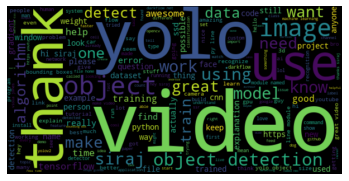

In [113]:
# Plotting Word Cloud for "comments_pre"
allWords = ' '.join([comments for comments in comments_pre['clean_comments']])
wordCloud = WordCloud(width = 600, height= 300, random_state = 20, max_font_size = 150).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



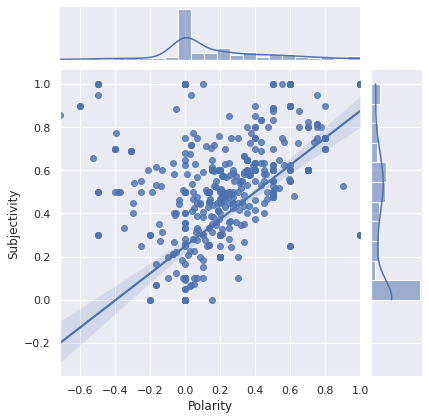

In [114]:
# Jointplot visualisation for "comments_pre" dataFrame
sns.jointplot("Polarity", "Subjectivity", data=comments_pre, kind='reg');


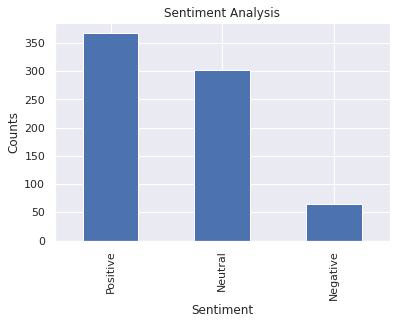

In [130]:
# Show the value count
comments_pre['Analysis'].value_counts()

# Plot and Visualise value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
comments_pre['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [115]:
print(comments_pre['Polarity'].mean())


0.17228626062605024


In [116]:
print(comments_pre['Subjectivity'].mean())

0.35631353818103434


**Stage 4.2:** Exploratory Data Analysis ('**comments_post**')

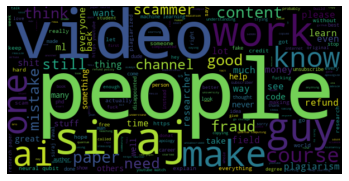

In [117]:
# Plotting Word Cloud for "comments_post"
allWords = ' '.join([comments for comments in comments_post['clean_comments']])
wordCloud = WordCloud(width = 600, height= 300, random_state = 20, max_font_size = 150).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



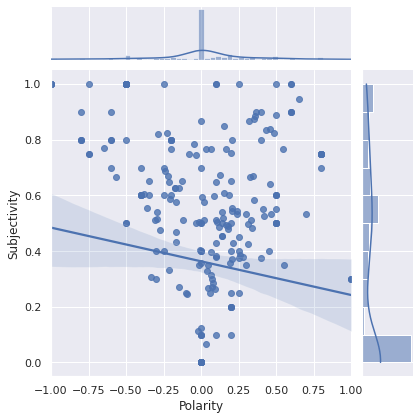

In [118]:
# Jointplot visualisation for "comments_post" dataFrame
sns.jointplot("Polarity", "Subjectivity", data=comments_post, kind='reg');


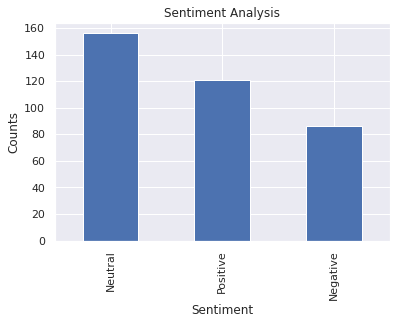

In [131]:
# Show the value count
comments_post['Analysis'].value_counts()

# Plot and Visualise value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
comments_post['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [119]:
print(comments_post['Polarity'].mean())

0.014172561506964977


In [120]:
print(comments_post['Subjectivity'].mean())

0.36131452524929786


**Stage 5 (Conclusion):**

Based on the initial research hypothesis, there is evidence that the YouTube channel received a lot more negative sentiments after 14-01-2019. The study shows that AI ethics goes a long way, as it only takes only ones mistake to bring a person's reputation down, especially on social media platforms. 

**References:**

[1] How to Build Your Own Dataset of YouTube Comments, https://towardsdatascience.com/how-to-build-your-own-dataset-of-youtube-comments-39a1e57aade

[2] Twitter Sentiment Analysis Using Python, https://www.youtube.com/watch?v=ujId4ipkBio

[3] The comments sections are WILD | YouTube sentiment analysis - Data science project for beginners, https://www.youtube.com/watch?v=kHOVWiZKpHM&t=81s

[4] seaborn.scatterplot, https://seaborn.pydata.org/generated/seaborn.scatterplot.html

[5] Analysis and Visualization of Subjectivity and Polarity of TwitterLocation Data, https://www.researchgate.net/publication/325493570_Analysis_and_visualization_of_subjectivity_and_polarity_of_Twitter_location_data